In [1]:
# ============================================================
# Notebook setup
# ============================================================

%load_ext autoreload
%autoreload 2
%matplotlib inline

import copy
import logging
import os

import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.cuda.amp import GradScaler
from torch.utils.data import DataLoader, TensorDataset

import semg_bss

# Configure log file
LOG_FILE = "semg_bss.log"
logging.basicConfig(filename=LOG_FILE, encoding='utf-8', level=logging.INFO, filemode="w")

# Path to dataset
DATA_DIR = "../Datasets/putemg"

# Parameters to set
FS_EMG = 5120  # sampling frequency
NEW_FS = 5120  # down-sampling frequency
MAX_COMP = 20  # target number of components
ORDERING = None  # "firing-rate", "neg-entropy" or None for recalibration
LOAD_SAVED_MODELS = True
SEED = 42

# Check CUDA
if torch.cuda.is_available():
    dev = torch.device("cuda:0")
    print("CUDA acceleration available and enabled.")
else:
    dev = torch.device("cpu")
    print("CUDA acceleration not available.")

CUDA acceleration available and enabled.


# Decomposition of sEMG Signals and Gesture Classification
The aim of this project is to decompose a sEMG signal of a gesture, obtain the MUAPs, and then classify the gesture. In particular, we'll train the decomposition model once on a training signal, which must be sufficiently informative about the gesture we want to recognize (*offline calibration*). Then, we'll reuse the decomposition model to transform new signals and classify them (*online analysis*).

## 1. Introduction to ICA-based Blind Source Separation
The original ICA formulation from [Hyvarinen et al.](https://www.cs.helsinki.fi/u/ahyvarin/papers/NN00new.pdf) relies on instantaneous mixing:

$\mathbf{X} = \mathbf{A}\mathbf{S}$

where

- $\mathbf{X}$ is the $N_\text{recording} \times N_\text{samples}$ matrix of observables (i.e. the sEMG recording);
- $\mathbf{S}$ is the $N_\text{components} \times N_\text{samples}$ matrix of the original signals (i.e. the MUAPs);
- $\mathbf{A}$ is the $N_\text{recording} \times N_\text{components}$ mixing matrix.

The FastICA algorithm was developed to address this formulation.

However, since the muscle fibers act as a low-pass filter, the resulting sEMG signal is a convolutive mixture of the MUAPs ([Holobar et al.](https://ieeexplore.ieee.org/document/4291854)):

$x_i(k)=\sum_{l=0}^{L-1} \sum_{j=1}^N h_{ij}(l)s_j(k-l)+n_i(k);\;\;\;\;i=1,\dots,M$

namely the matrix of electrode recordings $\mathbf{X}$ is obtained by performing a 1D convolution between a mixing filter $\mathbf{H}$ with size $L$ and the actual spike trains $\mathbf{S}$.

[Thomas et al.](https://ieeexplore.ieee.org/document/1605245) adapted FastICA in order to address convolutive mixtures.

## 2. putEMG dataset
This dataset contains the sEMG recordings of 44 subjects, acquired while they were performing 7 hand gestures (in addition to rest and idle gestures), during two recording sessions. In particular, the dataset provides 3 type of signals:

- **repeats_long**: subjects were instructed to perform 7 action blocks, where each block contains 8 repetitions of each active gesture.
- **repeats_short**: subjects were instructed to perform 7 action blocks, where each block contains 6 repetitions of each active gesture.
- **sequential**: subjects were instructed to perform 6 action blocks, where each block is a subsequent exectution of all active gestures.

The sEMG data were collected using 24 electrodes, with a sampling rate of 5120 Hz.

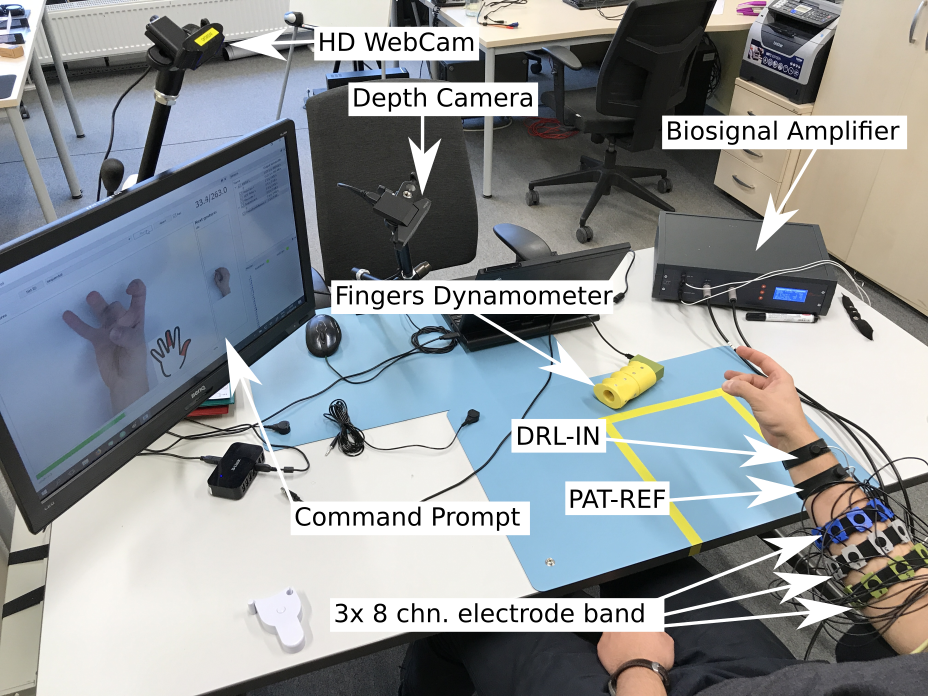

## 3. Decomposition
For now we will focus on the first subject and on the first session: first of all, let's visualize the repeats_long signal, that we'll use to calibrate the decomposition model.

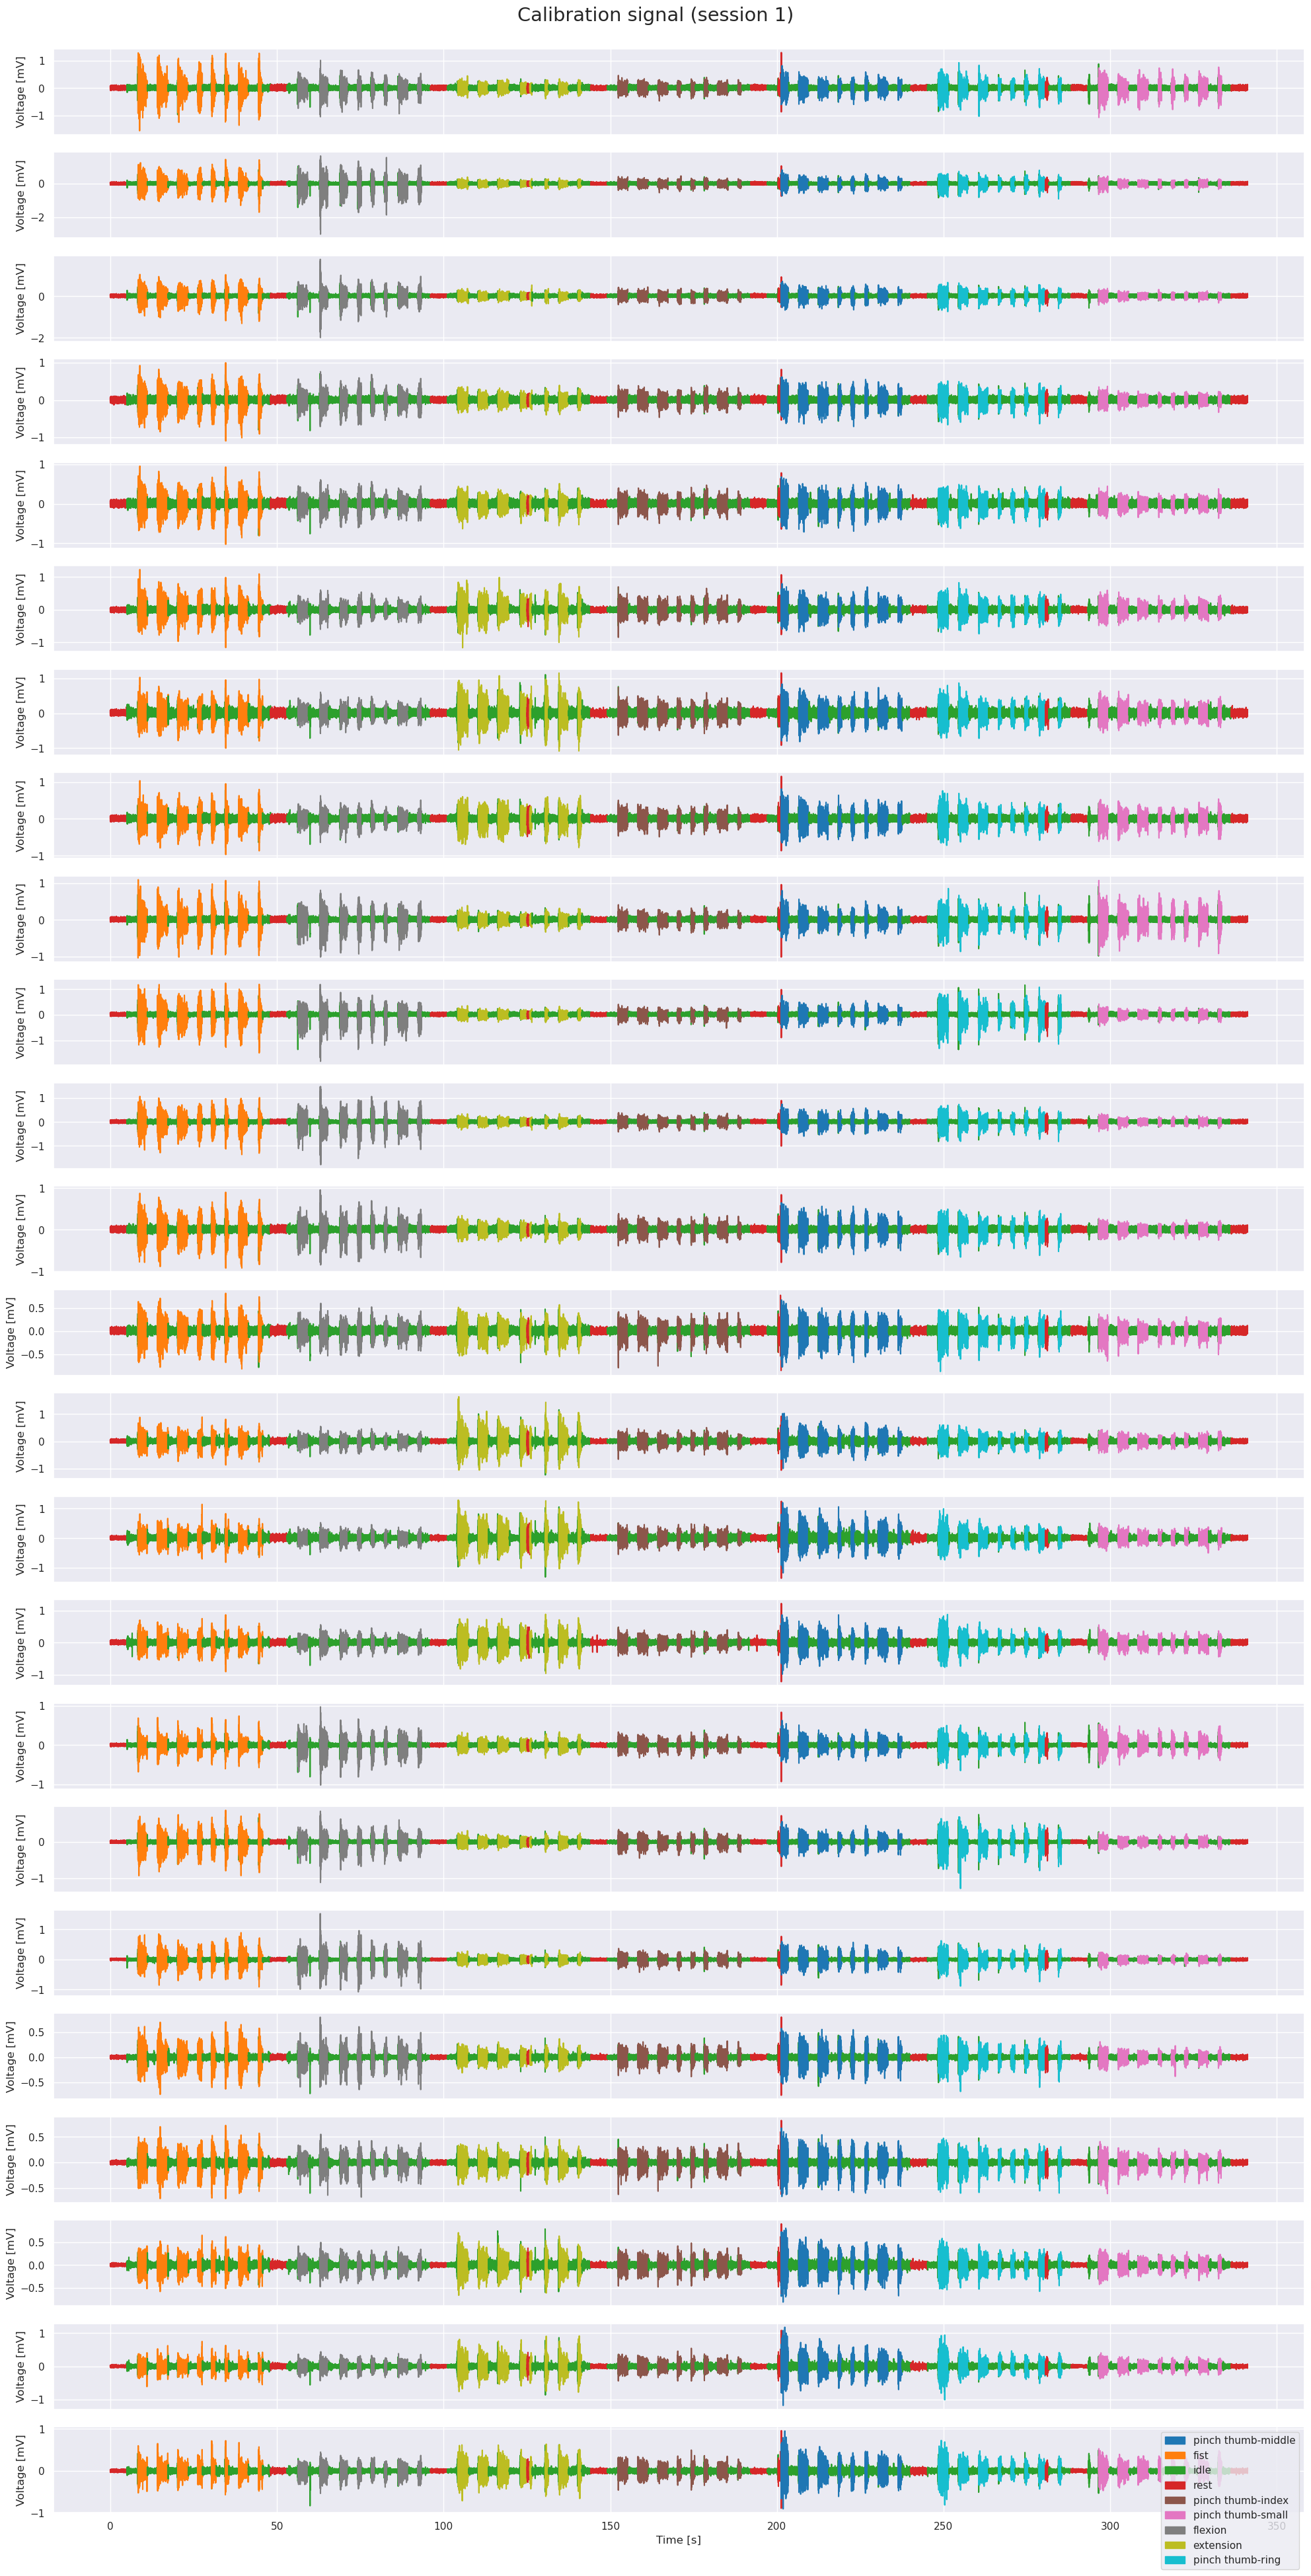

In [2]:
# Load signal
emg_calib_s1, labels_calib_s1 = semg_bss.datasets.put_emg.load_put_emg(
    DATA_DIR,
    subject=3,
    session=1,
    task_type="repeats_long"
)

# Filter it with 20-700 Hz band-pass filter + notch filter
emg_calib_s1 = semg_bss.preprocessing.filter_signal(
    emg_calib_s1,
    fs=FS_EMG,
    min_freq=20,
    max_freq=700,
    notch_freqs=(30, 50, 90, 60, 150),
    order=5
)

# Resample at lower frequency, if required
if NEW_FS != FS_EMG:
    emg_calib_s1, labels_calib_s1 = semg_bss.datasets.put_emg.down_sample(emg_calib_s1, labels_calib_s1, FS_EMG, NEW_FS)

# Plot it
semg_bss.plt.plot_signal(
    emg_calib_s1,
    fs=NEW_FS,
    title="Calibration signal (session 1)",
    labels=labels_calib_s1,
    fig_size=(20, 40)
)

To simplify the classification, let's focus on fewer gestures: in particular, we'll work on flexion and extension, and thus we'll keep only the slice from second 50 to 150.

In [3]:
cut_from = 50 * NEW_FS
cut_to = 150 * NEW_FS
calib_len = 100
emg_calib_s1 = emg_calib_s1[:, cut_from:cut_to]
labels_calib_s1 = [(l, l_from - cut_from, l_to - cut_from) for l, l_from, l_to in labels_calib_s1 if l_from >= cut_from and l_to < cut_to]

# Plot it
semg_bss.plt.plot_signal(
    emg_calib_s1,
    fs=NEW_FS,
    title="Calibration signal (session 1, [50-150] seconds)",
    labels=labels_calib_s1,
    resolution=5,
    fig_size=(20, 40)
)

As we can see, a contraction lasts roughly from 1 to 3 seconds, and for each gesture there are 8 contractions (performed in 50 seconds). Therefore, if we consider a minimum of 8 pulses-per-second (pps) and a maximum of 250 pps, the valid range for a MU would be:

- $\text{min\_spike\_pps} = \frac{8 \text{pps} \cdot 1 \text{s} \cdot 8}{50 \text{s}} = 1.28 \text{pps}$
- $\text{max\_spike\_pps} = \frac{250 \text{pps} \cdot 3 \text{s} \cdot 8}{50 \text{s}} = 120 \text{pps}$

Let's plot the signal's FFT spectrum.

In [4]:
semg_bss.plt.plot_fft_spectrum(
    emg_calib_s1,
    fs=NEW_FS,
    title="Calibration signal's spectrum (session 1)",
    fig_size=(20, 40)
)

The first step is signal extension: since we have a convolutive mixture, we must extend the signal by adding delayed copies, resulting in $f_e \times M$ channels (where $M$ is the n. of channels in the original signal). In particular, we set $f_e=8$.
Then, the extended signal is centered and whitened via eigenvalue decomposition.

In [5]:
f_e = 8
# Extend, center and whiten the concatenated signal
emg_ext = semg_bss.preprocessing.extend_signal(emg_calib_s1, f_e)
emg_center, mean_vec = semg_bss.preprocessing.center_signal(emg_ext)
emg_white, white_mtx = semg_bss.preprocessing.whiten_signal(emg_center)

# Extract gestures "flexion" and "extension"
g1_from, g1_to = next((idx_from, idx_to) for label, idx_from, idx_to in labels_calib_s1 if label == "flexion")
g1_emg = emg_calib_s1[:, g1_from:g1_to]
g2_from, g2_to = next((idx_from, idx_to) for label, idx_from, idx_to in labels_calib_s1 if label == "extension")
g2_emg = emg_calib_s1[:, g2_from:g2_to]

# Preprocess them with the pre-computed whitening matrix
tmp = semg_bss.preprocessing.extend_signal(g1_emg, f_e)
tmp -= mean_vec
g1_white = white_mtx @ tmp
tmp = semg_bss.preprocessing.extend_signal(g2_emg, f_e)
tmp -= mean_vec
g2_white = white_mtx @ tmp

semg_bss.plt.plot_correlation(
    array=[emg_ext, emg_white, g1_white, g2_white],
    title=["Extended signal", "Whitened signal", "Whitened signal (flexion)", "Whitened signal (extension)"],
    n_cols=4,
    fig_size=(20, 8)
)

# Free memory
del emg_ext
del emg_center
del emg_white
del white_mtx
del tmp
del g1_emg
del g1_white
del g2_emg
del g2_white

The logic behind FastICA and source improvement is encapsulated inside the `EMGSeparator` class: let's create one using $f_e=8$.

In [6]:
model_s1_path = f"decomp_models/1dof/{'recal' if ORDERING is None else ORDERING}/{MAX_COMP}/emg_separator_s1_{NEW_FS}.pkl"

if not LOAD_SAVED_MODELS:
    emg_separator_s1 = semg_bss.EMGSeparator(
        max_sources=MAX_COMP,
        samp_freq=NEW_FS,
        f_e=f_e,
        sorting_strategy=ORDERING,
        seed=SEED
    )
else:
    emg_separator_s1 = semg_bss.EMGSeparator.load_from_file(model_s1_path)

### Training
Let's calibrate the `EMGSeparator` instance on the repeats_long signal (truncated to the first 3 gestures).

Extracted 12 MUs.


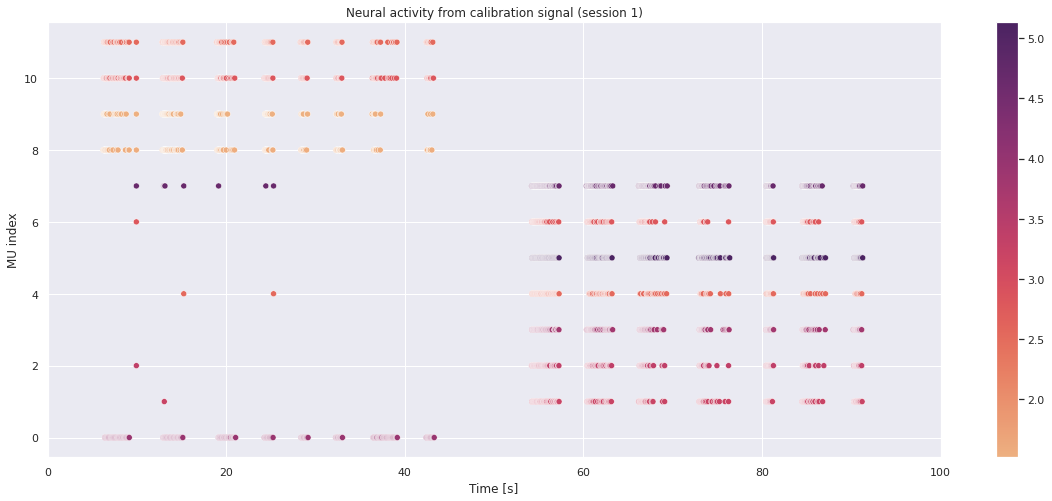

In [7]:
if not LOAD_SAVED_MODELS:
    # Calibrate instance on the given signal
    firings_calib_s1 = emg_separator_s1.calibrate(
        emg_calib_s1,
        min_spike_pps=1.28,
        max_spike_pps=120
    )
    # Save instance to file
    emg_separator_s1.save_to_file(model_s1_path)
else:
    firings_calib_s1 = emg_separator_s1.decompose(
        emg_calib_s1,
        min_spike_pps=1.28,
        max_spike_pps=120
    )
print(f"Extracted {emg_separator_s1.n_mu} MUs.")

# Visualize firings
semg_bss.plt.raster_plot(
    firings_calib_s1,
    title="Neural activity from calibration signal (session 1)",
    sig_span=(0, calib_len),
    fig_size=(20, 8)
)

# Free memory
del labels_calib_s1

### Test (visual)
Let's now load the repeats_short signal. For now we'll focus on binary classification, so let's extract the extension and flexion gestures

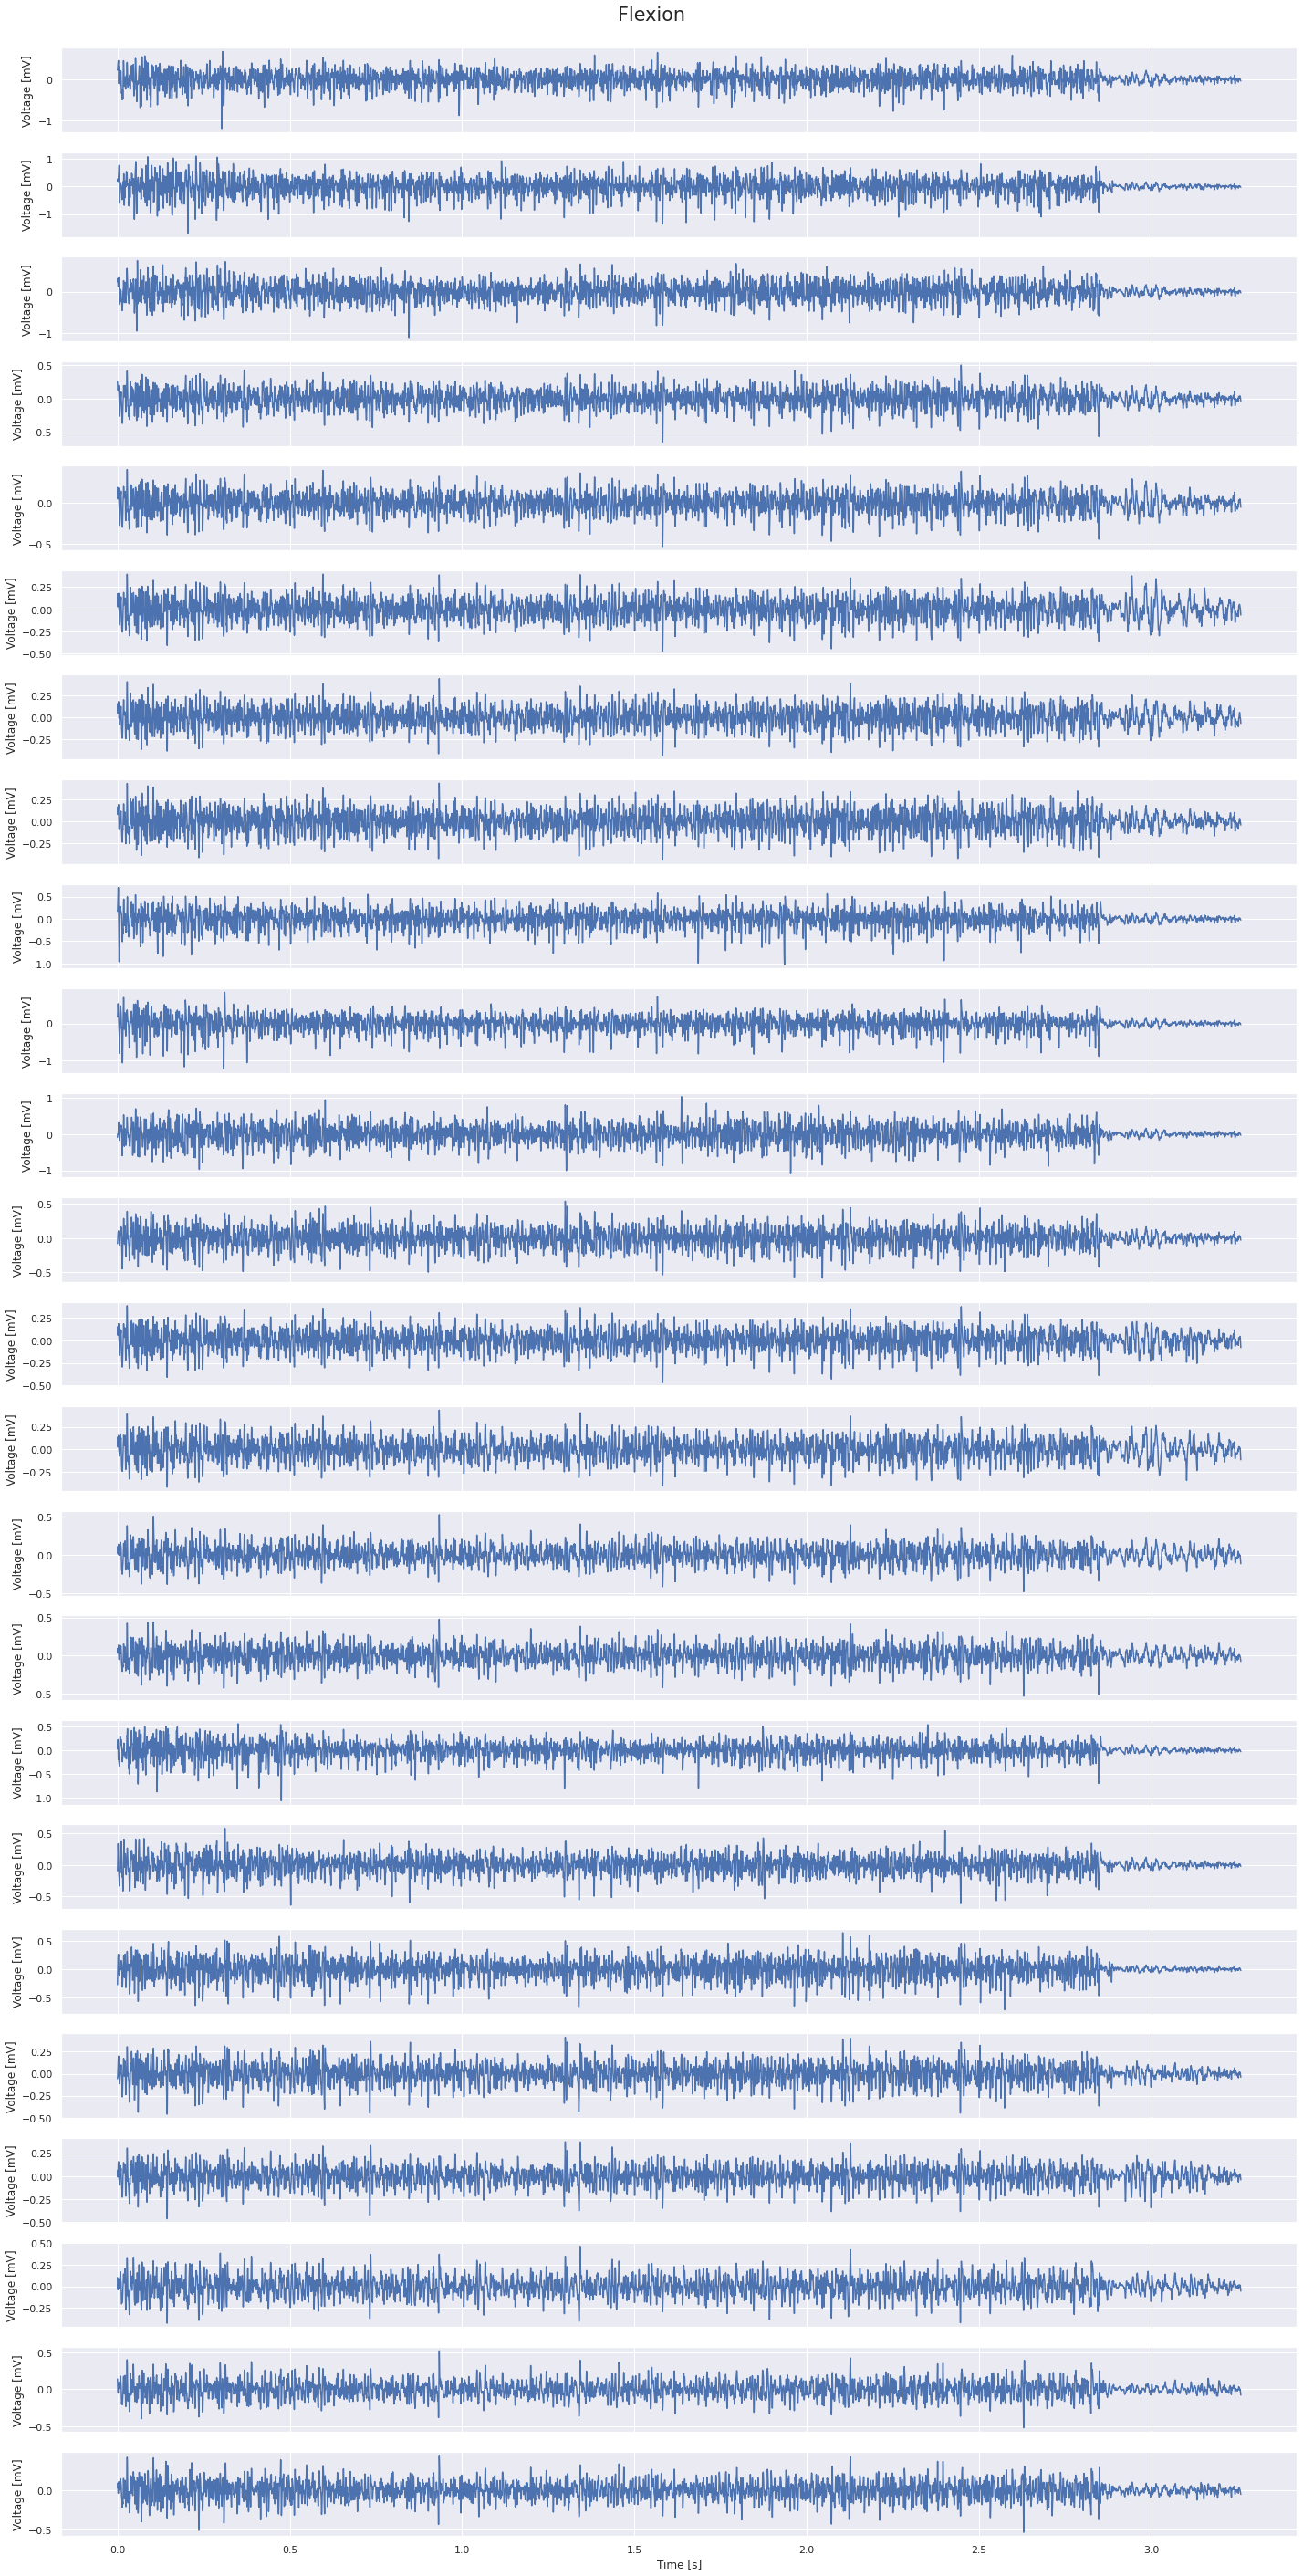

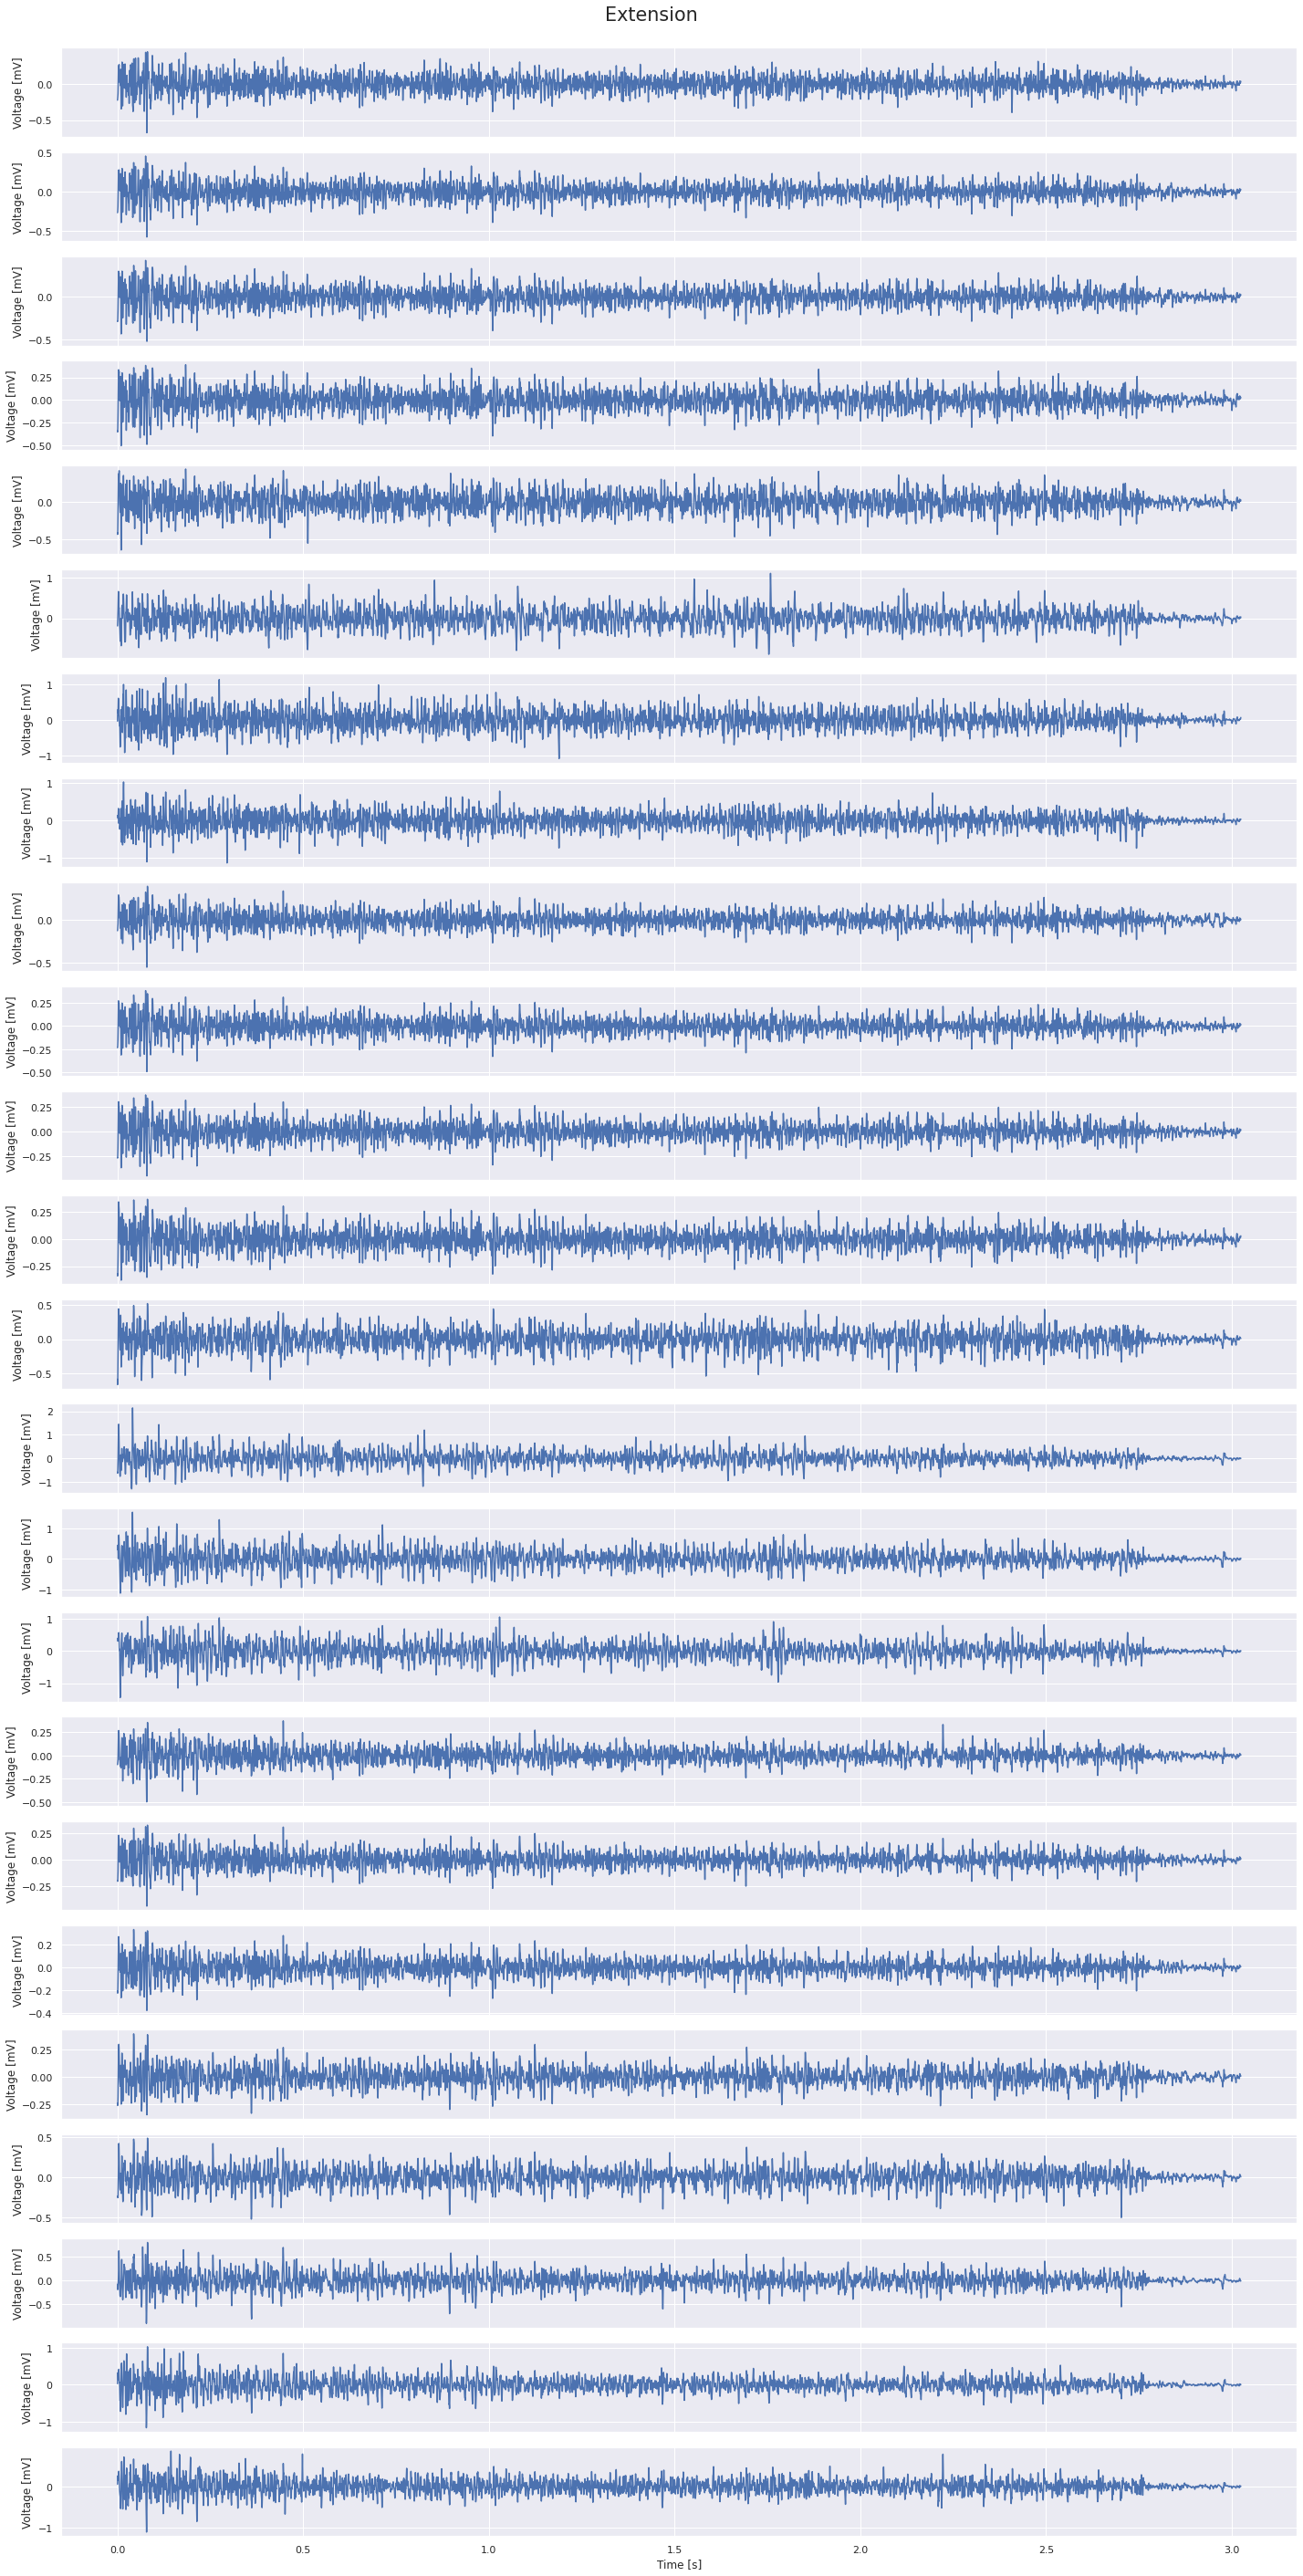

In [8]:
# Load signal
emg_test_s1, labels_test_s1 = semg_bss.datasets.put_emg.load_put_emg(
    DATA_DIR,
    subject=3,
    session=1,
    task_type="repeats_short"
)

# Filter it with 20-700 Hz band-pass filter + notch filter
emg_test_s1 = semg_bss.preprocessing.filter_signal(
    emg_test_s1,
    fs=FS_EMG,
    min_freq=20,
    max_freq=700,
    notch_freqs=(30, 50, 90, 60, 150),
    order=5
)

# Resample at lower frequency, if required
if NEW_FS != FS_EMG:
    emg_test_s1, labels_test_s1 = semg_bss.datasets.put_emg.down_sample(emg_test_s1, labels_test_s1, FS_EMG, NEW_FS)

# Extract gesture "flexion"
g1_from, g1_to = next((idx_from, idx_to) for label, idx_from, idx_to in labels_test_s1 if label == "flexion")
g1_emg = emg_test_s1[:, g1_from:g1_to]
semg_bss.plt.plot_signal(
    g1_emg,
    fs=NEW_FS,
    title="Flexion",
    fig_size=(20, 40)
)

# Extract gesture "extension"
g2_from, g2_to = next((idx_from, idx_to) for label, idx_from, idx_to in labels_test_s1 if label == "extension")
g2_emg = emg_test_s1[:, g2_from:g2_to]
semg_bss.plt.plot_signal(
    g2_emg,
    fs=NEW_FS,
    title="Extension",
    fig_size=(20, 40)
)

Let's decompose the two signals with the model trained previously.

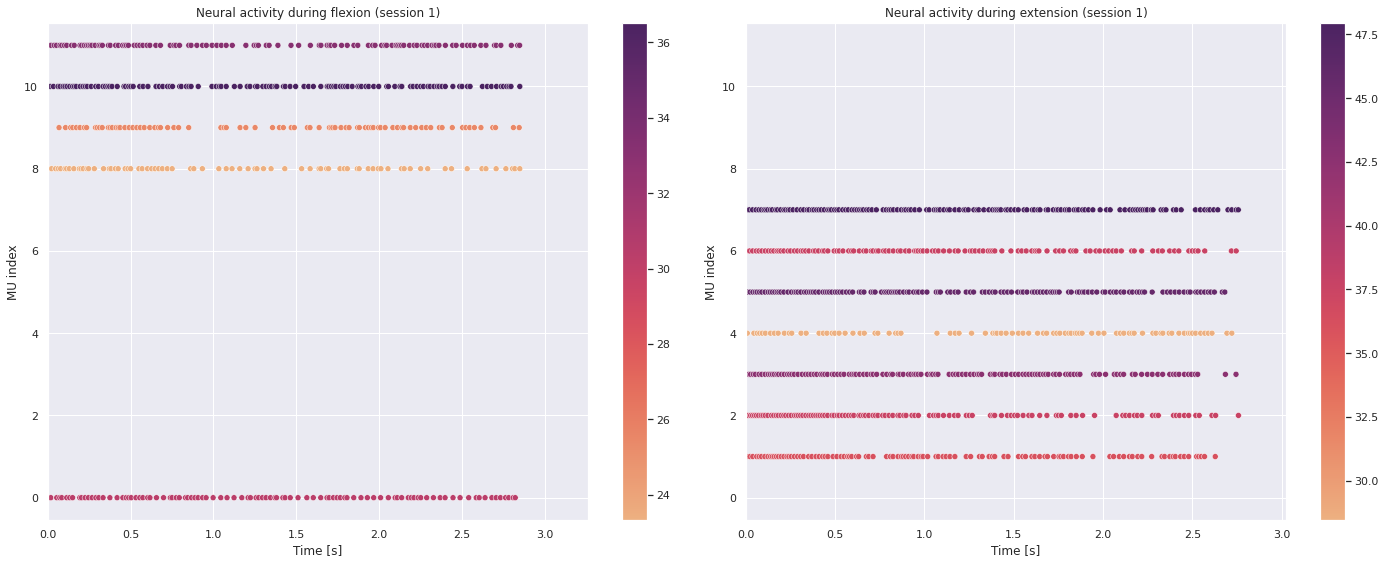

In [9]:
# Extract firings
g1_firings = emg_separator_s1.decompose(g1_emg)
g2_firings = emg_separator_s1.decompose(g2_emg)

semg_bss.plt.raster_plot(
    firings=[g1_firings, g2_firings],
    title=["Neural activity during flexion (session 1)", "Neural activity during extension (session 1)"],
    sig_span=[
        (0, g1_emg.shape[1] / NEW_FS),
        (0, g2_emg.shape[1] / NEW_FS)
    ],
    n_cols=2,
    fig_size=(20, 8)
)

# Free memory
del emg_test_s1
del labels_test_s1
del g1_emg
del g2_emg
del g1_firings
del g2_firings

As we can see the order of active MUs remains consistent with the calibration signal.

Now let's load the sample from session 2.

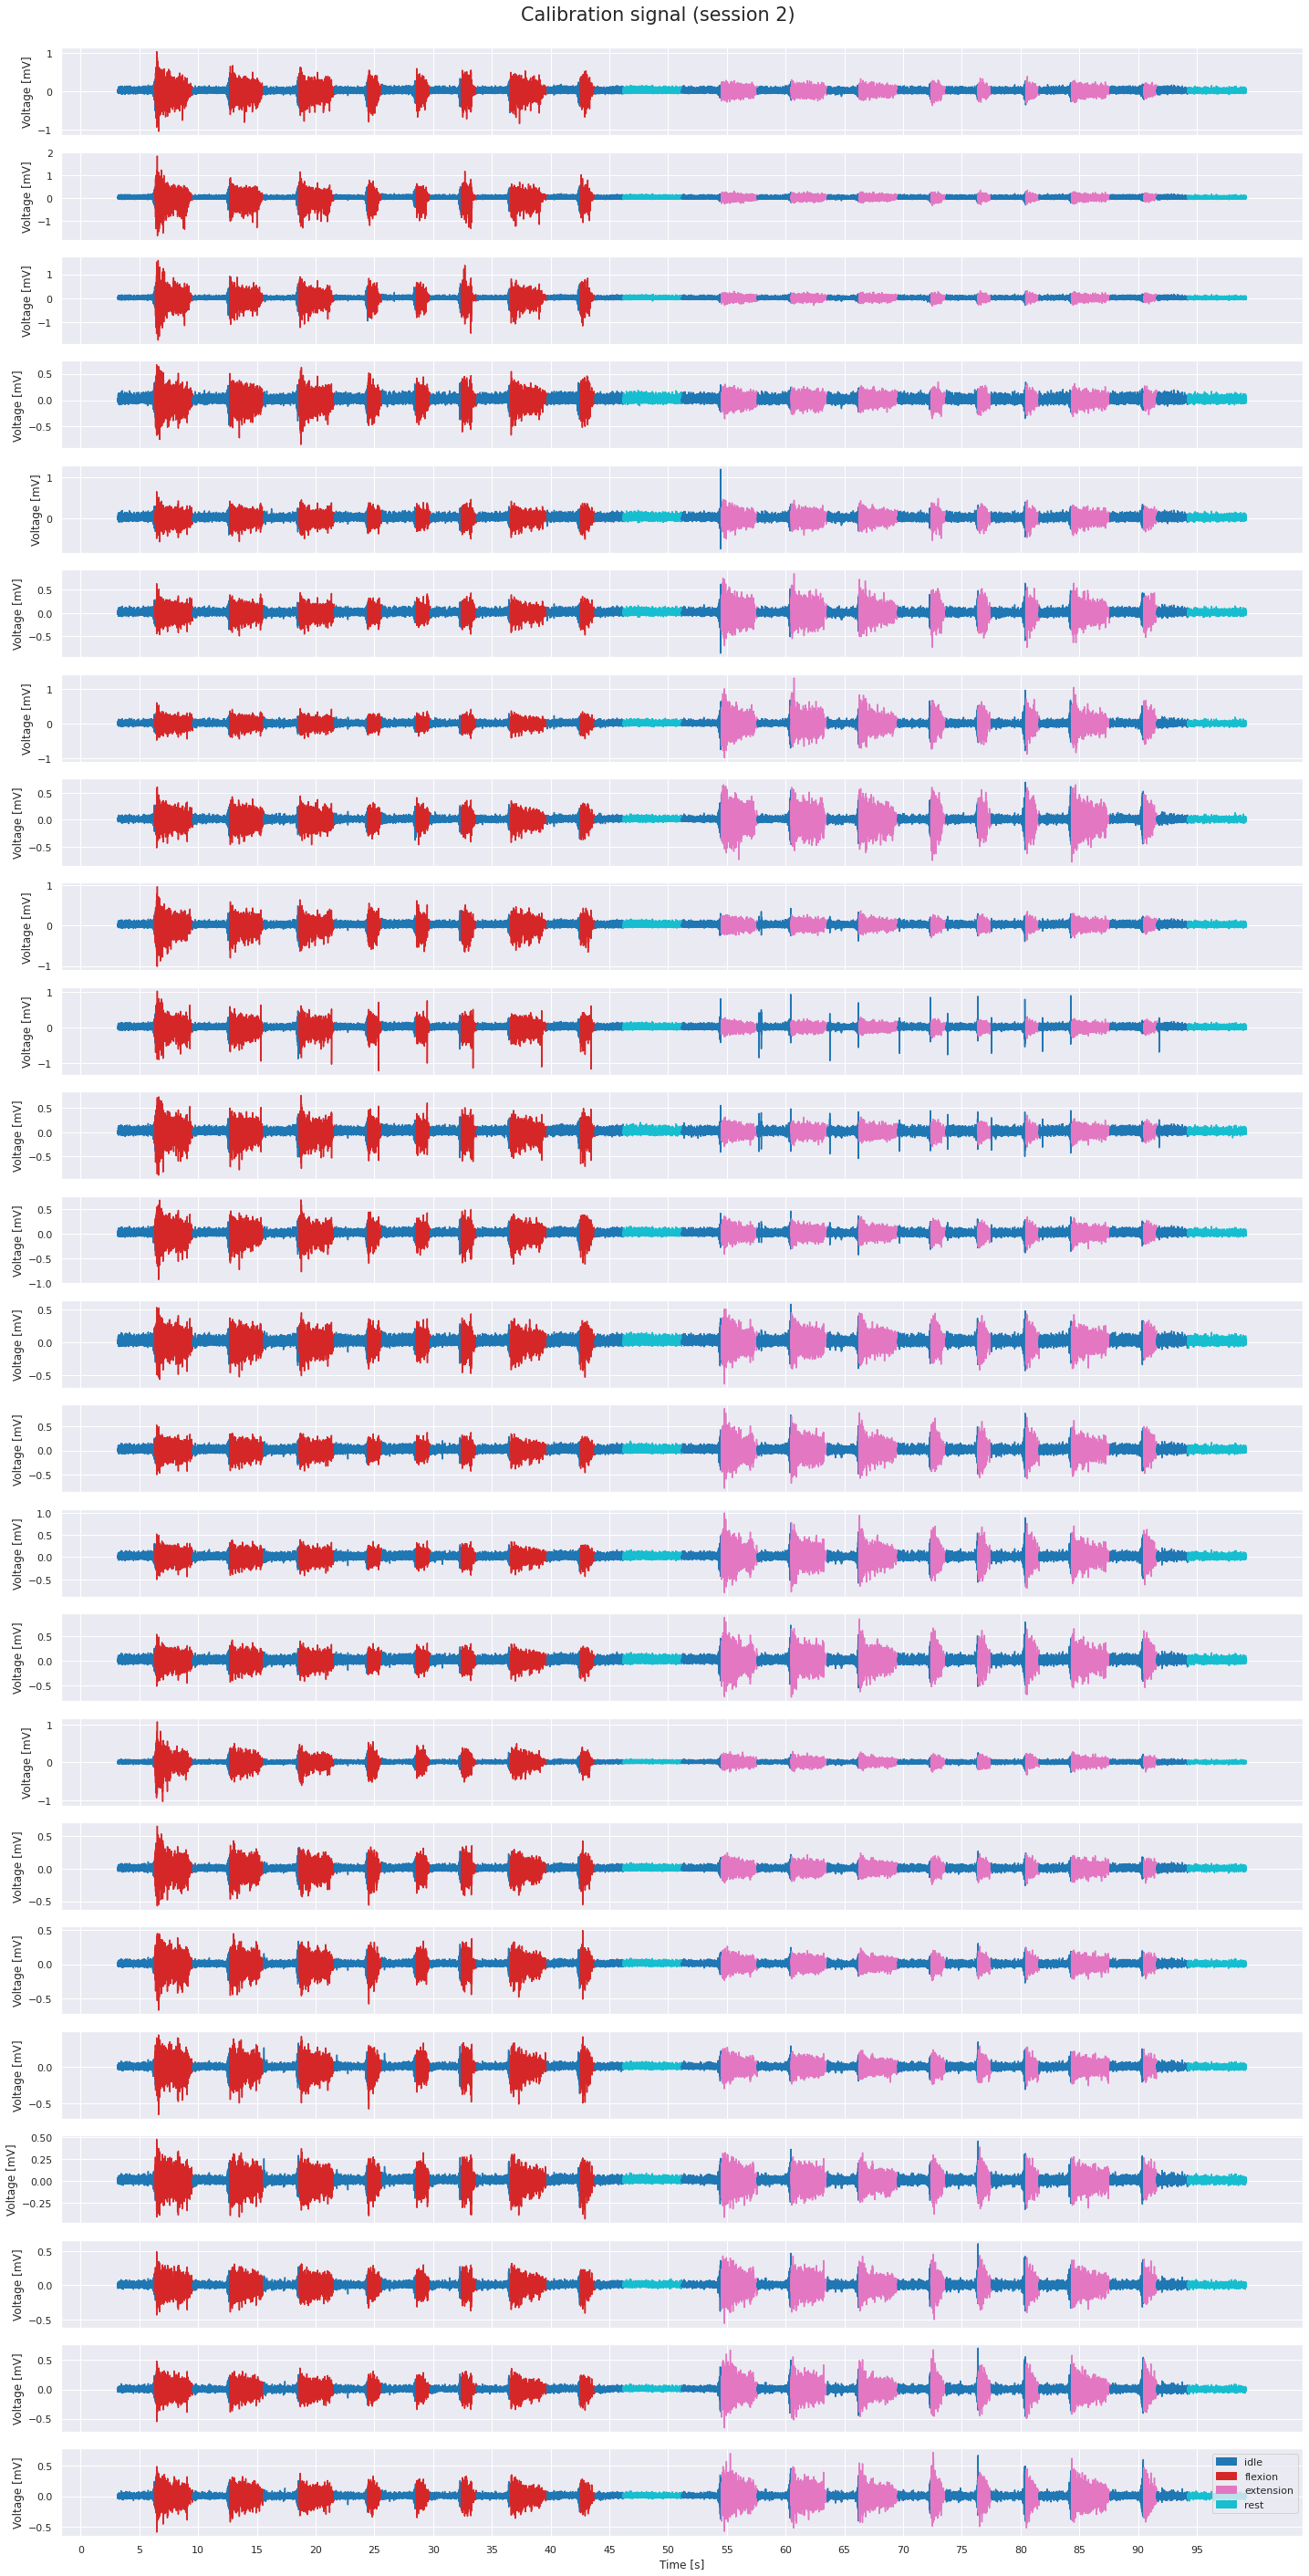

In [10]:
# Load signal
emg_calib_s2, labels_calib_s2 = semg_bss.datasets.put_emg.load_put_emg(
    DATA_DIR,
    subject=3,
    session=2,
    task_type="repeats_long"
)

# Filter it with 20-700 Hz band-pass filter + notch filter
emg_calib_s2 = semg_bss.preprocessing.filter_signal(
    emg_calib_s2,
    fs=FS_EMG,
    min_freq=20,
    max_freq=700,
    notch_freqs=(30, 50, 90, 60, 150),
    order=5
)

# Resample at lower frequency, if required
if NEW_FS != FS_EMG:
    emg_calib_s2, labels_calib_s2 = semg_bss.datasets.put_emg.down_sample(emg_calib_s2, labels_calib_s2, FS_EMG, NEW_FS)

# Cut it
cut_from = 50 * NEW_FS
cut_to = 150 * NEW_FS
emg_calib_s2 = emg_calib_s2[:, cut_from:cut_to]
labels_calib_s2 = [(l, l_from - cut_from, l_to - cut_to) for l, l_from, l_to in labels_calib_s2 if l_from >= cut_from and l_to < cut_to]

# Plot it
semg_bss.plt.plot_signal(
    emg_calib_s2,
    fs=NEW_FS,
    title="Calibration signal (session 2)",
    labels=labels_calib_s2,
    resolution=5,
    fig_size=(20, 40)
)

Let's either create a second model and calibrate it on the new signal, or clone the previous model and recalibrate it.

Extracted 12 MUs.


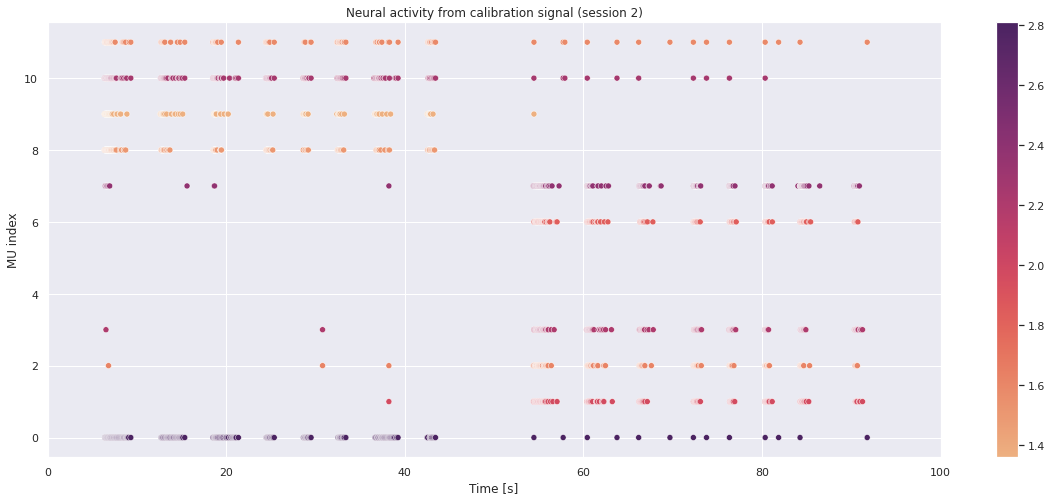

In [11]:
model_s2_path = f"decomp_models/1dof/{'recal' if ORDERING is None else ORDERING}/{MAX_COMP}/emg_separator_s2_{NEW_FS}.pkl"
if not LOAD_SAVED_MODELS:
    if ORDERING is None:  # recalibration
        # Make a copy of the separator
        emg_separator_s2 = copy.deepcopy(emg_separator_s1)
    else:
        # Create new separator
        emg_separator_s2 = semg_bss.EMGSeparator(
            max_sources=MAX_COMP,
            samp_freq=NEW_FS,
            f_e=f_e,
            sorting_strategy=ORDERING,
            seed=SEED
        )
else:
    emg_separator_s2 = semg_bss.EMGSeparator.load_from_file(model_s2_path)

if not LOAD_SAVED_MODELS:
    if ORDERING is None:  # recalibration
        # Recalibrate instance on the given signal
        firings_calib_s2 = emg_separator_s2.recalibrate(
            emg_calib_s2,
            min_spike_pps=1.28,
            max_spike_pps=120
        )
    else:
        firings_calib_s2 = emg_separator_s2.calibrate(
            emg_calib_s2,
            min_spike_pps=1.28,
            max_spike_pps=120
        )
    # Save instance to file
    emg_separator_s2.save_to_file(model_s2_path)
else:
    firings_calib_s2 = emg_separator_s2.decompose(
        emg_calib_s2,
        min_spike_pps=1.28,
        max_spike_pps=120
    )
print(f"Extracted {emg_separator_s2.n_mu} MUs.")

# Visualize firings
semg_bss.plt.raster_plot(
    firings_calib_s2,
    title="Neural activity from calibration signal (session 2)",
    sig_span=(0, calib_len),
    fig_size=(20, 8)
)

# Free memory
del labels_calib_s2

Let's compare the two firing patterns of the two sessions.

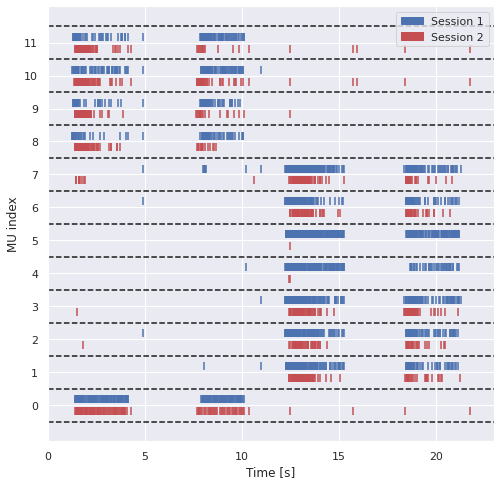

In [12]:
# import seaborn as sns
# sns.set_theme(style="whitegrid", font_scale=2)

sig1 = np.hstack([emg_calib_s1[:, 5 * FS_EMG:16 * FS_EMG], emg_calib_s1[:, 53 * FS_EMG:65 * FS_EMG]])
sig2 = np.hstack([emg_calib_s2[:, 5 * FS_EMG:16 * FS_EMG], emg_calib_s2[:, 53 * FS_EMG:65 * FS_EMG]])

semg_bss.plt.plot_firings_comparison(
    emg_separator_s1.decompose(sig1, min_spike_pps=0),
    emg_separator_s2.decompose(sig2, min_spike_pps=0),
    sig_span=(0, sig1.shape[1] / FS_EMG),
    fig_size=(8, 8)
)

# Free memory
del emg_calib_s1
del emg_calib_s2
del firings_calib_s1
del firings_calib_s2

## 4. Classification with SNN (binary, intra-session)
Let's prepare the training data for the classification task using two gestures: we'll use firings extracted from all the three types of signal. Let's focus on session 1 for now.

In [ ]:
gestures = ["flexion", "extension"]

firings_train = []
for task_type in ("repeats_long", "repeats_short"):
    # Load signal
    emg, labels = semg_bss.datasets.put_emg.load_put_emg(
        DATA_DIR,
        subject=3,
        session=1,
        task_type=task_type
    )

    # Filter it with 20-700 Hz band-pass filter + notch filter
    emg = semg_bss.preprocessing.filter_signal(
        emg,
        fs=FS_EMG,
        min_freq=20,
        max_freq=700,
        notch_freqs=(30, 50, 90, 60, 150),
        order=5
    )

    # Resample at lower frequency, if required
    if NEW_FS != FS_EMG:
        emg, labels = semg_bss.datasets.put_emg.down_sample(emg, labels, FS_EMG, NEW_FS)

    for gesture in gestures:
        # Extract gesture
        for g_from, g_to in [(idx_from, idx_to) for label, idx_from, idx_to in labels if label == gesture]:
            g_slice = emg[:, g_from:g_to]
            g_duration = (g_to - g_from) / NEW_FS
            firings = emg_separator_s1.decompose(g_slice)
            if not firings.empty:
                firings_train += [(firings, gesture, g_duration)]
            else:
                print("MU extraction failed on training sample")
            

print(f"Training samples: {len(firings_train)}")

firings_test = []
for task_type in ("sequential",):
    # Load signal
    emg, labels = semg_bss.datasets.put_emg.load_put_emg(
        DATA_DIR,
        subject=3,
        session=1,
        task_type=task_type
    )

    # Filter it with 20-700 Hz band-pass filter + notch filter
    emg = semg_bss.preprocessing.filter_signal(
        emg,
        fs=FS_EMG,
        min_freq=20,
        max_freq=700,
        notch_freqs=(30, 50, 90, 60, 150),
        order=5
    )

    # Resample at lower frequency, if required
    if NEW_FS != FS_EMG:
        emg, labels = semg_bss.datasets.put_emg.down_sample(emg, labels, FS_EMG, NEW_FS)

    for gesture in gestures:
        # Extract gesture
        for g_from, g_to in [(idx_from, idx_to) for label, idx_from, idx_to in labels if label == gesture]:
            g_slice = emg[:, g_from:g_to]
            g_duration = (g_to - g_from) / NEW_FS
            firings = emg_separator_s1.decompose(g_slice)
            if not firings.empty:
                firings_test += [(firings, gesture, g_duration)]
            else:
                print("MU extraction failed on test sample")

print(f"Test samples: {len(firings_test)}")

Let's define a SNN and train it several times.

In [ ]:
test_acc = []
for i in range(10):
    snn = semg_bss.clf.MUAPTClassifierSNN(
        n_inp=emg_separator_s1.n_mu,
        n_pool=20,
        classes=gestures,
        w_max=1.,
        max_pot=0.05,
        tau_pre=50.,
        tau_post=50.
    )
    hist = snn.train(firings_train)
    # semg_bss.plot_snn_hist(hist, fig_size=(20, 20))

    n_correct = 0
    n_total = 0
    for f in firings_test:
        gesture_pred = snn.inference(f)
        if gesture_pred == f[1]:
            n_correct += 1
        n_total += 1
    cur_acc = n_correct / n_total
    test_acc.append(cur_acc)
    print(f"Run {i} - Intra-session test accuracy: {cur_acc:.2%}")

print(f"Average test accuracy: {sum(test_acc) / len(test_acc):.2%}")

## 4. Classification with SNN (binary, inter-session)
Let's prepare the training data for the classification task using two gestures: we'll use firings extracted from all the three types of signal. Let's use session 1 for training and session 2 for test.

In [ ]:
gestures = ["flexion", "extension"]

firings_train = []
for task_type in ("repeats_long", "repeats_short", "sequential"):
    # Load signal
    emg, labels = semg_bss.datasets.put_emg.load_put_emg(
        DATA_DIR,
        subject=3,
        session=1,
        task_type=task_type
    )

    # Filter it with 20-700 Hz band-pass filter + notch filter
    emg = semg_bss.preprocessing.filter_signal(
        emg,
        fs=FS_EMG,
        min_freq=20,
        max_freq=700,
        notch_freqs=(30, 50, 90, 60, 150),
        order=5
    )

    # Resample at lower frequency, if required
    if NEW_FS != FS_EMG:
        emg, labels = semg_bss.datasets.put_emg.down_sample(emg, labels, FS_EMG, NEW_FS)

    for gesture in gestures:
        # Extract gesture
        for g_from, g_to in [(idx_from, idx_to) for label, idx_from, idx_to in labels if label == gesture]:
            g_slice = emg[:, g_from:g_to]
            g_duration = (g_to - g_from) / NEW_FS
            firings = emg_separator_s1.decompose(g_slice)
            if not firings.empty:
                firings_train += [(firings, gesture, g_duration)]
            else:
                print("MU extraction failed on training sample")

print(f"Training samples: {len(firings_train)}")

firings_test = []
for task_type in ("repeats_long", "repeats_short", "sequential"):
    # Load signal
    emg, labels = semg_bss.datasets.put_emg.load_put_emg(
        DATA_DIR,
        subject=3,
        session=2,
        task_type=task_type
    )

    # Filter it with 20-700 Hz band-pass filter + notch filter
    emg = semg_bss.preprocessing.filter_signal(
        emg,
        fs=FS_EMG,
        min_freq=20,
        max_freq=700,
        notch_freqs=(30, 50, 90, 60, 150),
        order=5
    )

    # Resample at lower frequency, if required
    if NEW_FS != FS_EMG:
        emg, labels = semg_bss.datasets.put_emg.down_sample(emg, labels, FS_EMG, NEW_FS)

    for gesture in gestures:
        # Extract gesture
        for g_from, g_to in [(idx_from, idx_to) for label, idx_from, idx_to in labels if label == gesture]:
            g_slice = emg[:, g_from:g_to]
            g_duration = (g_to - g_from) / NEW_FS
            firings = emg_separator_s2.decompose(g_slice)
            if not firings.empty:
                firings_test += [(firings, gesture, g_duration)]
            else:
                print("MU extraction failed on test sample")

print(f"Test samples: {len(firings_test)}")

Let's define a SNN and train it several times.

In [ ]:
test_acc = []
for i in range(10):
    snn = semg_bss.snn.SNN(
        n_inp=emg_separator_s1.n_mu,
        n_pool=20,
        classes=gestures,
        w_max=1.,
        max_pot=0.05,
        tau_pre=50.,
        tau_post=50.
    )
    hist = snn.train(firings_train)
    # semg_bss.plot_snn_hist(hist, fig_size=(20, 20))

    n_correct = 0
    n_total = 0
    for f in firings_test:
        gesture_pred = snn.inference(f)
        if gesture_pred == f[1]:
            n_correct += 1
        n_total += 1
    cur_acc = n_correct / n_total
    test_acc.append(cur_acc)
    print(f"Run {i} - Inter-session test accuracy: {cur_acc:.2%}")

print(f"Average test accuracy: {sum(test_acc) / len(test_acc):.2%}")

## 4. Classification with MLP (binary, intra-session)
Let's prepare the training data for the classification task using two gestures: we'll use 500ms-long slices of all the three types of signal. Let's focus on session 1 for now.

In [13]:
slice_len = 0.5  # = 500 ms
step_len = 0.1  # = 100 ms

# Gesture dict
gestures = ("flexion", "extension")
gesture_dict = {g: i for i, g in enumerate(gestures)}

# Use repeats_long and repeats_short for training
X_trainval = np.zeros(shape=(0, emg_separator_s1.n_mu * int(slice_len * NEW_FS)), dtype=np.float32)
y_trainval = np.zeros(shape=(0,), dtype=np.float32)
for task_type in ("repeats_long", "repeats_short"):
    # Load signal
    emg, labels = semg_bss.datasets.put_emg.load_put_emg(
        DATA_DIR,
        subject=3,
        session=1,
        task_type=task_type
    )

    # Filter it with 20-700 Hz band-pass filter + notch filter
    emg = semg_bss.preprocessing.filter_signal(
        emg,
        fs=FS_EMG,
        min_freq=20,
        max_freq=700,
        notch_freqs=(30, 50, 90, 60, 150),
        order=5
    )

    # Resample at lower frequency, if required
    if NEW_FS != FS_EMG:
        emg, labels = semg_bss.datasets.put_emg.down_sample(emg, labels, FS_EMG, NEW_FS)
    
    for gesture in gestures:
        g_labels = [(idx_from, idx_to) for label, idx_from, idx_to in labels if label == gesture]
        # Iterate over gesture repetitions
        for i, (g_from, g_to) in enumerate(g_labels):
            # Extract gesture and decompose it
            g_slice = emg[:, g_from:g_to]
            firings = emg_separator_s1.decompose(g_slice)
            # Iterate over slices
            start = 0
            stop = (g_to - g_from) / FS_EMG
            
            while start < stop - slice_len:
                if firings.empty:  # unexpected empty firings during contraction
                    print(f"MU extraction failed on segment {i + 1} of gesture {gesture}.")
                    break
                else:  # expected non-empty firings during contraction
                    # Slice firings
                    cur_firings = firings[(firings["Firing time"] >= start) & (firings["Firing time"] < start + slice_len)]
                    X_trainval = np.concatenate([
                        X_trainval,
                        semg_bss.clf.df_to_dense(
                            cur_firings,
                            emg_separator_s1.n_mu,
                            offset=start,
                            sig_len=slice_len,
                            fs=FS_EMG
                        ).flatten().reshape(1, -1)
                    ])
                    y_trainval = np.concatenate([y_trainval, (gesture_dict[gesture],)])
                    start += step_len

# Use sequential for test
X_test = np.zeros(shape=(0, emg_separator_s1.n_mu * int(slice_len * NEW_FS)), dtype=np.float32)
y_test = np.zeros(shape=(0,), dtype=np.float32)
for task_type in ("sequential",):
    # Load signal
    emg, labels = semg_bss.datasets.put_emg.load_put_emg(
        DATA_DIR,
        subject=3,
        session=1,
        task_type=task_type
    )

    # Filter it with 20-700 Hz band-pass filter + notch filter
    emg = semg_bss.preprocessing.filter_signal(
        emg,
        fs=FS_EMG,
        min_freq=20,
        max_freq=700,
        notch_freqs=(30, 50, 90, 60, 150),
        order=5
    )

    # Resample at lower frequency, if required
    if NEW_FS != FS_EMG:
        emg, labels = semg_bss.datasets.put_emg.down_sample(emg, labels, FS_EMG, NEW_FS)
    
    for gesture in gestures:
        g_labels = [(idx_from, idx_to) for label, idx_from, idx_to in labels if label == gesture]
        # Iterate over gesture repetitions
        for i, (g_from, g_to) in enumerate(g_labels):
            # Extract gesture and decompose it
            g_slice = emg[:, g_from:g_to]
            firings = emg_separator_s1.decompose(g_slice)
            # Iterate over slices
            start = 0
            stop = (g_to - g_from) / FS_EMG
            
            while start < stop - slice_len:
                if firings.empty:  # unexpected empty firings during contraction
                    print(f"MU extraction failed on segment {i + 1} of gesture {gesture}.")
                    break
                else:  # expected non-empty firings during contraction
                    # Slice firings
                    cur_firings = firings[(firings["Firing time"] >= start) & (firings["Firing time"] < start + slice_len)]
                    X_test = np.concatenate([
                        X_test,
                        semg_bss.clf.df_to_dense(
                            cur_firings,
                            emg_separator_s1.n_mu,
                            offset=start,
                            sig_len=slice_len,
                            fs=FS_EMG
                        ).flatten().reshape(1, -1)
                    ])
                    y_test = np.concatenate([y_test, (gesture_dict[gesture],)])
                    start += step_len

# Split trainval in training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2)

print("Shape of training data:", X_train.shape, y_train.shape)
print("Shape of validation data:", X_val.shape, y_val.shape)
print("Shape of test data:", X_test.shape, y_test.shape)

Shape of training data: (370, 30720) (370,)
Shape of validation data: (93, 30720) (93,)
Shape of test data: (195, 30720) (195,)


In [14]:
# Convert to Torch Dataset
X_train_t = torch.from_numpy(X_train)
y_train_t = torch.from_numpy(y_train)
train_data = TensorDataset(X_train_t, y_train_t)
X_val_t = torch.from_numpy(X_val)
y_val_t = torch.from_numpy(y_val)
val_data = TensorDataset(X_val_t, y_val_t)

# Create DataLoader
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=True)

Let's define a simple MLP classifier and train it several times.

Run 1 - Test accuracy: 100.00%
Run 2 - Test accuracy: 100.00%
Run 3 - Test accuracy: 100.00%
Run 4 - Test accuracy: 100.00%
Run 5 - Test accuracy: 100.00%
Run 6 - Test accuracy: 100.00%
Run 7 - Test accuracy: 100.00%
Run 8 - Test accuracy: 100.00%
Run 9 - Test accuracy: 100.00%
Run 10 - Test accuracy: 100.00%


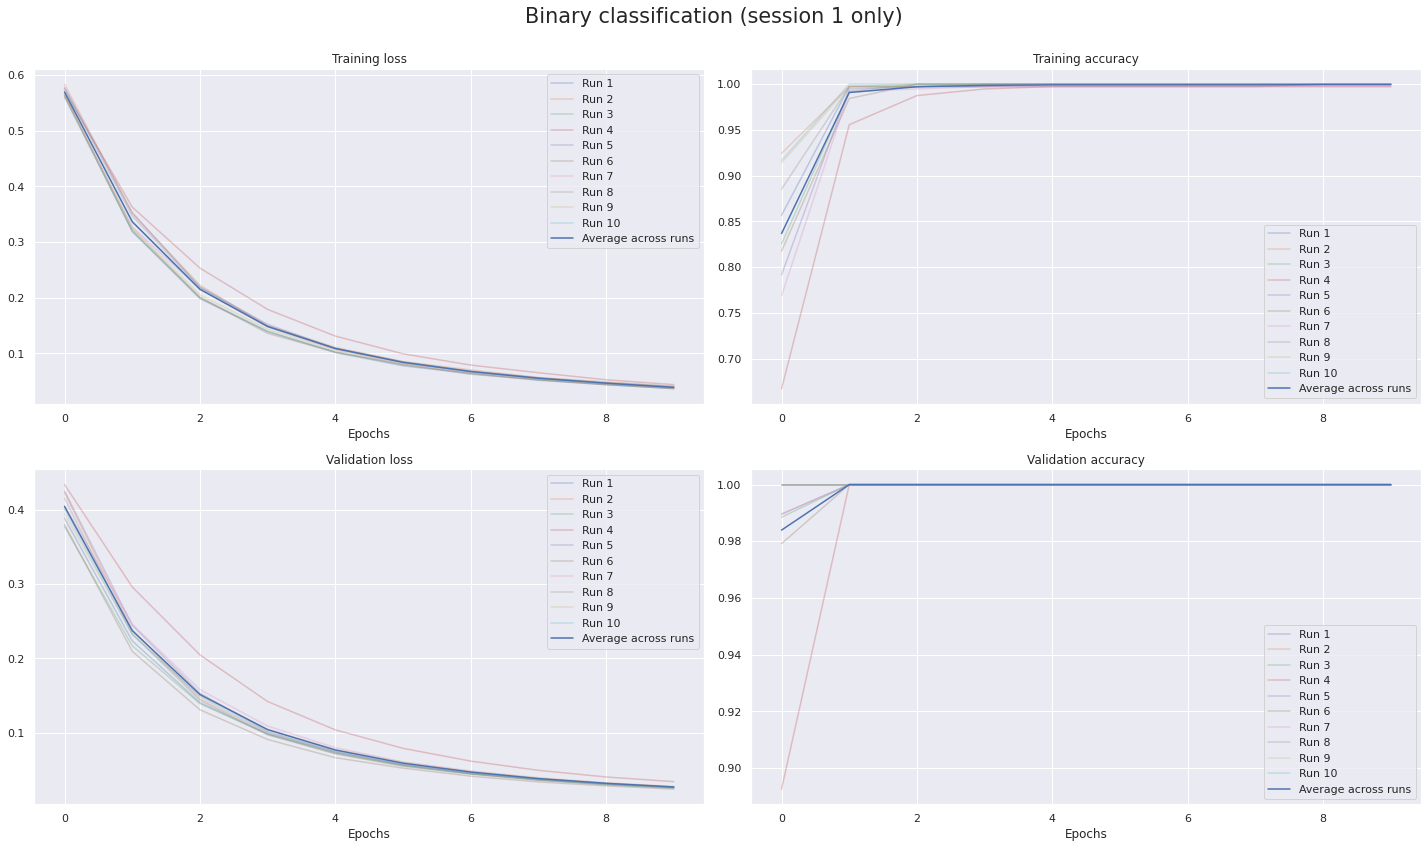

Average test accuracy: 100.00%


In [15]:
hist = {}
test_acc = []
for r in range(10):
    # Create classifier
    clf = semg_bss.clf.MUAPTClassifierMLP(
        n_in=X_train.shape[1],
        n_out=1,
        hidden_struct=(32,)
    ).to(dev)  # move to GPU, if available
    
    # Define criterion
    criterion = nn.BCEWithLogitsLoss()
    # Define optimizer
    optimizer = optim.Adam(clf.parameters(), weight_decay=1e-4)
    # Define checkpoint file
    checkpoint_path = os.path.join("mlp_models", "mlp_intra.pt")

    # Train model
    hist[r] = semg_bss.clf.training_loop(
        clf,
        train_loader,
        val_loader,
        criterion,
        optimizer,
        epochs=10,
        device=dev,
        checkpoint_path=checkpoint_path,
        early_stopping="val_loss",
        patience=2,
        delta=0
    )
    
    # Test it
    y_pred_test = np.zeros_like(y_test)
    for i in range(X_test.shape[0]):
        y_pred_test[i] = semg_bss.clf.inference(
            clf,
            x=torch.Tensor(X_test[i]).to(dev),
            device=dev
        )
    cur_test_acc = accuracy_score(y_test, y_pred_test)
    print(f"Run {r + 1} - Test accuracy: {cur_test_acc:.2%}")
    test_acc.append(cur_test_acc)
    
    clf = clf.cpu()  # move back to CPU

semg_bss.plt.plot_classifier_hist(
    hist,
    validation=True,
    title="Binary classification (session 1 only)",
    fig_size=(20, 12)
)

print(f"Average test accuracy: {sum(test_acc) / len(test_acc):.2%}")

## 4. Classification with MLP (binary, inter-session)
Let's prepare the training data for the classification task using two gestures: we'll use 500ms-long slices of all the three types of signal. Let's use session 1 for training and session 2 for test.

In [16]:
slice_len = 0.5  # = 500 ms
step_len = 0.1  # = 100 ms

# Gesture dict
gestures = ("flexion", "extension")
gesture_dict = {g: i for i, g in enumerate(gestures)}

min_n_mu = min((emg_separator_s1.n_mu, emg_separator_s2.n_mu))

# Use all subsets for test
X_trainval = np.zeros(shape=(0, min_n_mu * int(slice_len * NEW_FS)), dtype=np.float32)
y_trainval = np.zeros(shape=(0,), dtype=np.float32)
for task_type in ("repeats_long", "repeats_short", "sequential"):
    # Load signal
    emg, labels = semg_bss.datasets.put_emg.load_put_emg(
        DATA_DIR,
        subject=3,
        session=1,
        task_type=task_type
    )

    # Filter it with 20-700 Hz band-pass filter + notch filter
    emg = semg_bss.preprocessing.filter_signal(
        emg,
        fs=FS_EMG,
        min_freq=20,
        max_freq=700,
        notch_freqs=(30, 50, 90, 60, 150),
        order=5
    )

    # Resample at lower frequency, if required
    if NEW_FS != FS_EMG:
        emg, labels = semg_bss.datasets.put_emg.down_sample(emg, labels, FS_EMG, NEW_FS)
    
    for gesture in gestures:
        g_labels = [(idx_from, idx_to) for label, idx_from, idx_to in labels if label == gesture]
        # Iterate over gesture repetitions
        for i, (g_from, g_to) in enumerate(g_labels):
            # Extract gesture and decompose it
            g_slice = emg[:, g_from:g_to]
            firings = emg_separator_s1.decompose(g_slice)
            # Iterate over slices
            start = 0
            stop = (g_to - g_from) / FS_EMG
            
            while start < stop - slice_len:
                if firings.empty:  # unexpected empty firings during contraction
                    print(f"MU extraction failed on segment {i + 1} of gesture {gesture}.")
                    break
                else:  # expected non-empty firings during contraction
                    # Slice firings
                    cur_firings = firings[(firings["Firing time"] >= start) & (firings["Firing time"] < start + slice_len)]
                    X_trainval = np.concatenate([
                        X_trainval,
                        semg_bss.clf.df_to_dense(
                            cur_firings,
                            min_n_mu,
                            offset=start,
                            sig_len=slice_len,
                            fs=FS_EMG
                        ).flatten().reshape(1, -1)
                    ])
                    y_trainval = np.concatenate([y_trainval, (gesture_dict[gesture],)])
                    start += step_len

# Use all subsets for test
X_test = np.zeros(shape=(0, min_n_mu * int(slice_len * NEW_FS)), dtype=np.float32)
y_test = np.zeros(shape=(0,), dtype=np.float32)
for task_type in ("repeats_long", "repeats_short", "sequential"):
    # Load signal
    emg, labels = semg_bss.datasets.put_emg.load_put_emg(
        DATA_DIR,
        subject=3,
        session=2,
        task_type=task_type
    )

    # Filter it with 20-700 Hz band-pass filter + notch filter
    emg = semg_bss.preprocessing.filter_signal(
        emg,
        fs=FS_EMG,
        min_freq=20,
        max_freq=700,
        notch_freqs=(30, 50, 90, 60, 150),
        order=5
    )

    # Resample at lower frequency, if required
    if NEW_FS != FS_EMG:
        emg, labels = semg_bss.datasets.put_emg.down_sample(emg, labels, FS_EMG, NEW_FS)
    
    for gesture in gestures:
        g_labels = [(idx_from, idx_to) for label, idx_from, idx_to in labels if label == gesture]
        # Iterate over gesture repetitions
        for i, (g_from, g_to) in enumerate(g_labels):
            # Extract gesture and decompose it
            g_slice = emg[:, g_from:g_to]
            firings = emg_separator_s2.decompose(g_slice)
            # Iterate over slices
            start = 0
            stop = (g_to - g_from) / FS_EMG
            
            while start < stop - slice_len:
                if firings.empty:  # unexpected empty firings during contraction
                    print(f"MU extraction failed on segment {i + 1} of gesture {gesture}.")
                    break
                else:  # expected non-empty firings during contraction
                    # Slice firings
                    cur_firings = firings[(firings["Firing time"] >= start) & (firings["Firing time"] < start + slice_len)]
                    X_test = np.concatenate([
                        X_test,
                        semg_bss.clf.df_to_dense(
                            cur_firings,
                            min_n_mu,
                            offset=start,
                            sig_len=slice_len,
                            fs=FS_EMG
                        ).flatten().reshape(1, -1)
                    ])
                    y_test = np.concatenate([y_test, (gesture_dict[gesture],)])
                    start += step_len

# Split trainval in training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2)

print("Shape of training data:", X_train.shape, y_train.shape)
print("Shape of validation data:", X_val.shape, y_val.shape)
print("Shape of test data:", X_test.shape, y_test.shape)

Shape of training data: (526, 30720) (526,)
Shape of validation data: (132, 30720) (132,)
Shape of test data: (699, 30720) (699,)


In [17]:
# Convert to Torch Dataset
X_train_t = torch.from_numpy(X_train)
y_train_t = torch.from_numpy(y_train)
train_data = TensorDataset(X_train_t, y_train_t)
X_val_t = torch.from_numpy(X_val)
y_val_t = torch.from_numpy(y_val)
val_data = TensorDataset(X_val_t, y_val_t)

# Create DataLoader
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=True)

Let's define a simple MLP classifier and train it several times.

Run 1 - Test accuracy: 91.85%
Run 2 - Test accuracy: 95.99%
Run 3 - Test accuracy: 90.70%
Run 4 - Test accuracy: 92.13%
Run 5 - Test accuracy: 89.84%
Run 6 - Test accuracy: 91.70%
Run 7 - Test accuracy: 95.99%
Run 8 - Test accuracy: 100.00%
Run 9 - Test accuracy: 91.42%
Run 10 - Test accuracy: 91.99%


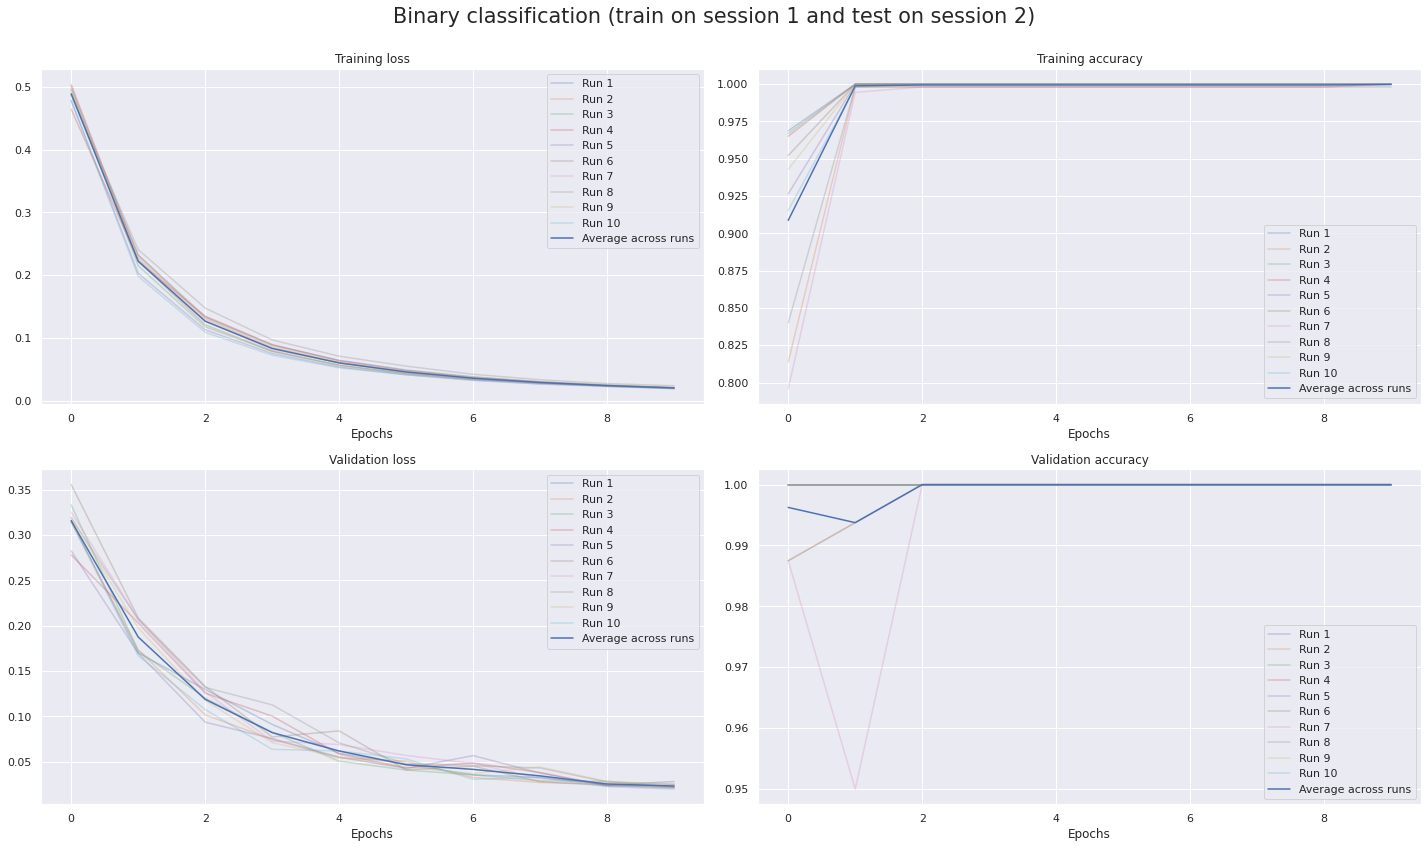

Average test accuracy: 93.16%


In [18]:
hist = {}
test_acc = []
for r in range(10):
    # Create classifier
    clf = semg_bss.clf.MUAPTClassifierMLP(
        n_in=X_train.shape[1],
        n_out=1,
        hidden_struct=(32,)
    ).to(dev)  # move to GPU, if available
    
    # Define criterion
    criterion = nn.BCEWithLogitsLoss()
    # Define optimizer
    optimizer = optim.Adam(clf.parameters(), weight_decay=1e-4)
    # Define checkpoint file
    checkpoint_path = os.path.join("mlp_models", "mlp_inter.pt")

    # Train model
    hist[r] = semg_bss.clf.training_loop(
        clf,
        train_loader,
        val_loader,
        criterion,
        optimizer,
        epochs=10,
        device=dev,
        checkpoint_path=checkpoint_path,
        early_stopping="val_loss",
        patience=2,
        delta=0
    )
    
    # Test it
    y_pred_test = np.zeros_like(y_test)
    for i in range(X_test.shape[0]):
        y_pred_test[i] = semg_bss.clf.inference(
            clf,
            x=torch.Tensor(X_test[i]).to(dev),
            device=dev
        )
    cur_test_acc = accuracy_score(y_test, y_pred_test)
    print(f"Run {r + 1} - Test accuracy: {cur_test_acc:.2%}")
    test_acc.append(cur_test_acc)
    
    clf = clf.cpu()  # move back to CPU

semg_bss.plt.plot_classifier_hist(
    hist,
    validation=True,
    title="Binary classification (train on session 1 and test on session 2)",
    fig_size=(20, 12)
)

print(f"Average test accuracy: {sum(test_acc) / len(test_acc):.2%}")